In [25]:
import sys
import pandas as pd
from pathlib import Path
import numpy as np
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import contextily as cx

# Add project root to Python path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import src.config as config

In [2]:
from src.loadProcessed import load_location_effects

data = load_location_effects()

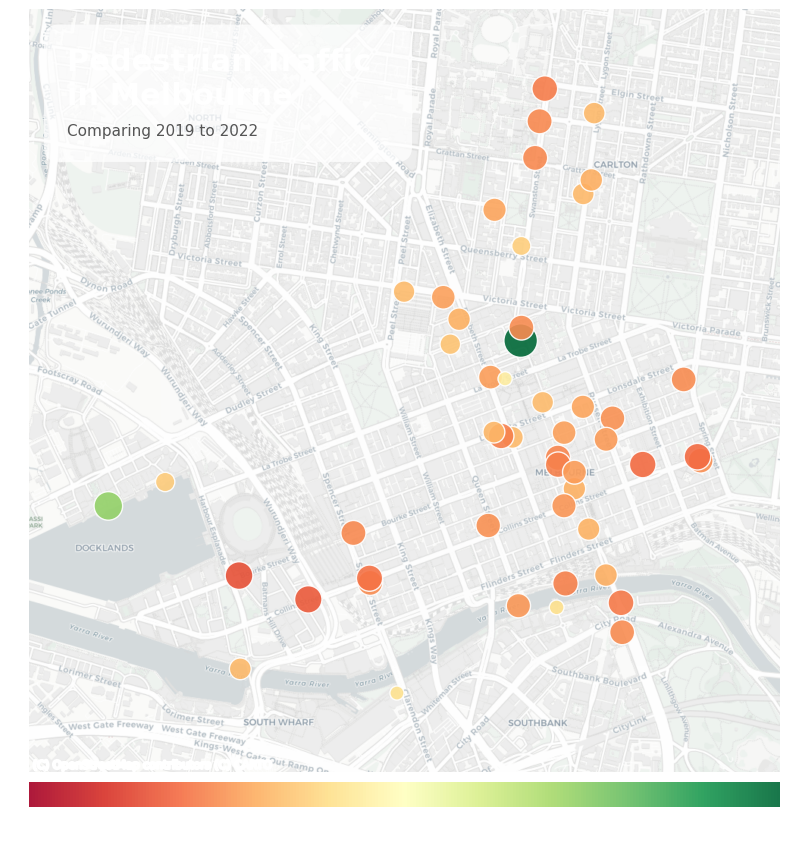

In [73]:
from pyproj import Transformer
import matplotlib.patches as patches

plot_data = data.copy()
plot_data['magnitude'] = plot_data['percentage_change'].abs()

# Convert lat/lon to Web Mercator (meters) for Contextily
transformer = Transformer.from_crs("EPSG:4326", "EPSG:3857", always_xy=True)
plot_data['x'], plot_data['y'] = transformer.transform(plot_data['longitude'].values, plot_data['latitude'].values)

fig, ax = plt.subplots(figsize=(8, 10))

# Scatter points
sc = ax.scatter(
    plot_data['x'], plot_data['y'],
    cmap='RdYlGn', 
    c=plot_data['percentage_change'],
    vmin=-100, vmax=plot_data['percentage_change'].max(),
    edgecolors='white',
    s= 50 * np.sqrt(plot_data['magnitude']),
    alpha=.9,
    zorder=2
)

# Add colourbar
cbar = fig.colorbar(sc, ax=ax, orientation='horizontal', 
                    fraction=0.03, pad=0.01, aspect=30)
cbar.set_label('% Change in Pedestrian Traffic', fontsize=10, weight='bold')
cbar.outline.set_visible(False)

# Set limits with a small buffer
buffer = 500
ax.set_xlim(plot_data['x'].min() - buffer, plot_data['x'].max() + buffer)
ax.set_ylim(plot_data['y'].min() - buffer, plot_data['y'].max() + buffer)

# Stops map from being stretched
ax.set_aspect('equal')

# Add basemap
cx.add_basemap(ax, source=cx.providers.CartoDB.Positron)
ax.set_axis_off()

# Add Title Box

ax.text(0.05, 0.95, "Pedestrian Traffic\nin Melbourne", 
        transform=ax.transAxes, 
        fontsize=22, fontweight='bold', 
        va='top', ha='left',
        linespacing=1.2,
        zorder=11)

ax.text(0.05, 0.85, "Comparing 2019 to 2022", 
        transform=ax.transAxes, 
        fontsize=11, color='#555555',
        va='top', ha='left',
        zorder=11)

ax.add_artist(patches.FancyBboxPatch(
    (0.04, 0.82), 0.45, 0.14, # (x, y), width, height in axes fraction
    transform=ax.transAxes,
    boxstyle="round,pad=0.02",
    facecolor='white', 
    edgecolor='none', 
    alpha=0.75, 
    zorder=10
))

plt.tight_layout()
plt.show()


In [ ]:
import json
import cmasher as cmr
import matplotlib.colors as mplcolors

pydeck_data = data.copy()
pydeck_data['absolute_change'] = abs(pydeck_data['percentage_change'])

# Apply colourmap to data

cmap = cmr.get_sub_cmap("cmr.watermelon", 0.0, 1.0)
cmap = cmap.reversed()

normalised_colour_map = mplcolors.TwoSlopeNorm(
    vmin=data['percentage_change'].min(),
    vcenter=0,
    vmax=data['percentage_change'].max()
)

def cmr_to_rgb(value):
    r, g, b, _ = cmap(normalised_colour_map(value))
    return [int(255*r), int(255*g), int(255*b)]

pydeck_data['colour'] = pydeck_data['percentage_change'].apply(cmr_to_rgb)

export_cols = [
    "longitude",
    "latitude",
    "percentage_change",
    "absolute_change",
    "sensor_description",
    "colour"
]

pydeck_data[export_cols].to_json(
    "../webapp/resources/pedestrian_data.json",
    orient="records"
)

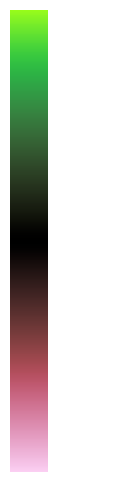

In [66]:
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'

# Create a figure specifically for the colorbar
fig, ax = plt.subplots(figsize=(1, 6)) # Adjust size as needed (width, height)
fig.subplots_adjust(right=0.5)

sm = mpl.cm.ScalarMappable(norm=normalised_colour_map, cmap=cmap)
sm.set_array([])

cb = fig.colorbar(sm, cax=ax, orientation='vertical')
cb.set_label('Percentage Change (%)', fontsize=12, color='white')
cb.outline.set_visible(False)
plt.savefig("../webapp/resources/colourbar.svg", transparent=True, bbox_inches='tight')